In [205]:
import websocket
import json
import time
import threading
import uuid
import pandas as pd
from datetime import datetime
import logging

class TradingViewDataFetcher:
    def __init__(self, log_level=logging.WARNING):
        """
        Initialize the TradingView data fetcher with configurable logging.
        
        Args:
            log_level: Logging level (default: WARNING to suppress info messages)
        """
        logging.basicConfig(level=log_level, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)
        
        # Default WebSocket URL (can be changed if needed)
        self.ws_url = "wss://prodata.tradingview.com/socket.io/websocket"
        
        # Default headers
        self.headers = {
            "Origin": "https://www.tradingview.com",
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }

    def fetch_data(self, symbol, exchange="NASDAQ", interval="D", num_bars=100, timeout=20, alt_urls=None):
        """
        Fetch historical price data from TradingView.
        
        Args:
            symbol: Trading symbol (e.g., "AAPL")
            exchange: Exchange name (e.g., "NASDAQ")
            interval: Time interval (e.g., "D" for daily, "W" for weekly, "M" for monthly, 
                     or "1" for 1 minute, "5" for 5 minutes, etc.)
            num_bars: Number of bars to request
            timeout: Maximum time to wait for data in seconds
            alt_urls: List of alternative WebSocket URLs to try if the primary fails
            
        Returns:
            pandas.DataFrame: DataFrame containing OHLCV data
        """
        urls_to_try = [self.ws_url]
        if alt_urls:
            urls_to_try.extend(alt_urls)
        
        for url in urls_to_try:
            self.logger.info(f"Trying WebSocket URL: {url}")
            
            # Reset state for each attempt
            self.session_id = f"qs_{uuid.uuid4().hex[:12]}"
            self.chart_session = f"cs_{uuid.uuid4().hex[:12]}"
            self.received_data = []
            self.error_occurred = False
            
            # Create and start WebSocket
            websocket.enableTrace(False)  # Set to True for verbose WebSocket logs
            ws = websocket.WebSocketApp(
                url,
                header=[f"{k}: {v}" for k, v in self.headers.items()],
                on_open=self._on_open(symbol, exchange, interval, num_bars),
                on_message=self._on_message,
                on_error=self._on_error,
                on_close=self._on_close
            )
            
            wst = threading.Thread(target=ws.run_forever)
            wst.daemon = True
            wst.start()
            
            try:
                # Wait for data
                start_time = time.time()
                while time.time() - start_time < timeout:
                    if self.error_occurred:
                        self.logger.error("Connection error detected, trying next URL if available")
                        break
                    
                    if len(self.received_data) >= num_bars/2:
                        self.logger.info(f"Received sufficient data: {len(self.received_data)} bars")
                        break
                        
                    time.sleep(0.5)
                
                # If we have data, process and return it
                if self.received_data:
                    ws.close()
                    return self._process_data()
                
            except KeyboardInterrupt:
                self.logger.info("Interrupted by user")
            finally:
                ws.close()
        
        # If we get here, all URLs failed
        self.logger.error("Failed to retrieve data from all WebSocket URLs")
        return None

    def _process_data(self):
        """Process the received data into a DataFrame."""
        df = pd.DataFrame(self.received_data)
        if not df.empty:
            df['Date'] = pd.to_datetime(df['Date'], unit='s')
            df = df.sort_values('Date')
            #df.set_index('Date', inplace=True)
            return df
        return None

    def _on_open(self, symbol, exchange, interval, num_bars):
        """Prepare the on_open callback with the required parameters."""
        def on_open_callback(ws):
            self.logger.info("WebSocket connection established")
            
            def run():
                try:
                    self._send_message(ws, "set_auth_token", ["unauthorized_user_token"])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "chart_create_session", [self.chart_session, ""])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "switch_timezone", [self.chart_session, "Etc/UTC"])
                    time.sleep(0.2)
                    
                    full_symbol = f"{exchange}:{symbol}"
                    symbol_payload = json.dumps({"symbol": full_symbol, "adjustment": "splits"})
                    self._send_message(ws, "resolve_symbol", [self.chart_session, "symbol_1", f"={symbol_payload}"])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "create_series", [self.chart_session, "s1", "s1", "symbol_1", interval, num_bars, ""])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "chart_create_study", [self.chart_session, "st1", "st1", "sds_1", full_symbol, interval, num_bars, ""])
                    
                    self.logger.info(f"Requested {num_bars} {interval} bars for {full_symbol}")
                except Exception as e:
                    self.logger.error(f"Error in initialization sequence: {e}")
            
            thread = threading.Thread(target=run)
            thread.daemon = True
            thread.start()
        
        return on_open_callback

    def _send_message(self, ws, method, params):
        """Send a properly formatted message to TradingView WebSocket."""
        try:
            data = json.dumps({"m": method, "p": params})
            message = f"~m~{len(data)}~m~{data}"
            ws.send(message)
            self.logger.debug(f"Sent: {method} - {params[:50]}{'...' if len(str(params)) > 50 else ''}")
        except Exception as e:
            self.logger.error(f"Error sending message {method}: {e}")

    def _on_message(self, ws, message):
        """Handle incoming WebSocket messages."""
        if message == "~h~":
            self.logger.debug("Received heartbeat, sending pong")
            ws.send("~h~")
            return
        
        if not message.startswith("~m~"):
            return
        
        try:
            msg_parts = message.split("~m~")
            for i in range(0, len(msg_parts)):
                if msg_parts[i] and msg_parts[i].isdigit() and i + 1 < len(msg_parts):
                    content = msg_parts[i+1]
                    if content and content.startswith("{"):
                        try:
                            data = json.loads(content)
                            
                            if isinstance(data, dict) and data.get("m") == "timescale_update":
                                self.logger.debug("Found timescale_update message")
                                payload = data.get("p", [])
                                if len(payload) > 1 and isinstance(payload[1], dict):
                                    for series_id, series_data in payload[1].items():
                                        if "s" in series_data and isinstance(series_data["s"], list):
                                            bars_count = len(series_data["s"])
                                            self.logger.debug(f"Found {bars_count} price bars")
                                            
                                            for bar in series_data["s"]:
                                                if "v" in bar and len(bar["v"]) >= 5:
                                                    ts, o, h, l, c = bar["v"][:5]
                                                    volume = bar["v"][5] if len(bar["v"]) > 5 else None
                                                    self.received_data.append({
                                                        "Date": ts,
                                                        "Open": o,
                                                        "High": h,
                                                        "Low": l,
                                                        "Close": c,
                                                        "Volume": volume
                                                    })
                        except json.JSONDecodeError:
                            self.logger.debug(f"Failed to parse JSON: {content[:50]}...")
        except Exception as e:
            self.logger.error(f"Error processing message: {e}")

    def _on_error(self, ws, error):
        """Handle WebSocket errors."""
        self.error_occurred = True
        self.logger.error(f"WebSocket error: {error}")

    def _on_close(self, ws, close_status_code, close_msg):
        """Handle WebSocket connection close."""
        self.logger.debug(f"WebSocket closed: {close_status_code} - {close_msg}")


# Example usage
def get_data(symbol, exchange="NASDAQ", interval="D", bars=5000, log_level=logging.WARNING):
    """
    Simple function to fetch data from TradingView.
    
    Args:
        symbol: Trading symbol (e.g., "AAPL")
        exchange: Exchange name (default: "NASDAQ")
        interval: Time interval (default: "D" for daily)
        bars: Number of bars to request (default: 5000)
        log_level: Logging level (default: WARNING - minimal output)
    
    Returns:
        pandas.DataFrame: DataFrame with OHLCV data or None if failure
    """
    fetcher = TradingViewDataFetcher(log_level=log_level)
    
    # Alternative URLs to try if the primary fails
    alt_urls = [
        "wss://data.tradingview.com/socket.io/websocket",
        "wss://s.tradingview.com/socket.io/websocket"
    ]
    
    return fetcher.fetch_data(
        symbol=symbol,
        exchange=exchange,
        interval=interval,
        num_bars=bars,
        alt_urls=alt_urls
    )
import re 

def occ_to_yahoo(occ):
    """
    Convert OCC option symbol (e.g., TSLA250613P00300000) to Yahoo format (e.g., TSLA250613P300.0).
    Handles tickers of any length and all valid strike formats, always includes one decimal.
    """
    m = re.match(r'^([A-Z0-9]{1,6})(\d{6})([CP])(\d{8})$', occ)
    if not m:
        raise ValueError("Invalid OCC option symbol format")
    symbol, date, opt_type, strike_raw = m.groups()
    strike = int(strike_raw) / 1000
    strike_str = f"{strike:.1f}"  # Always one decimal place

    yahoo = f"{symbol}{date}{opt_type}{strike_str}"
    return yahoo




In [206]:
import yfinance as yf
import pandas as pd
pd.set_option('display.max_rows', None)  # Show all rows

## Fetching options chain for a specific ticker
ticker = "TSLA"
expiry = "2025-06-13"  

def get_options_chain(symbol):
    stock = yf.Ticker(symbol)
    all_options = []
    for expiry in stock.options:
        chain = stock.option_chain(expiry)
        calls = chain.calls.copy()
        puts = chain.puts.copy()
        calls['type'] = 'call'
        puts['type'] = 'put'
        calls['expiry'] = expiry
        puts['expiry'] = expiry
        all_options.append(calls)
        all_options.append(puts)
    options_chain = pd.concat(all_options, ignore_index=True)
    return options_chain.sort_values(by="expiry", ascending=True)
## Adjusts returned Frame 
df = get_options_chain(ticker)
print(df["expiry"].unique())
print(f"{ticker} Current price : {yf.Ticker(ticker).info['currentPrice']}")
print(f"Exchange : {yf.Ticker(ticker).info['exchange']}")
exchange = yf.Ticker(ticker).info['exchange']
df = df[df["expiry"] == expiry]

df.sort_values(by="strike", ascending=True, inplace=True)
key_cols = ['contractSymbol','lastTradeDate','strike', 'type', 'expiry', 'lastPrice', 'bid', 'ask', 'volume', 'openInterest','impliedVolatility']
df = df[[col for col in key_cols if col in df.columns]]


from IPython.display import display, HTML
html = f"""
<div style='height: 200px; overflow: auto; width: fit-content'>
    <style>
        table {{ border-collapse: collapse; }}
        thead th {{
            position: sticky;
            top: 0;
            background-color: Black;
            z-index: 1;
        }}
    </style>
    {df.to_html(index=False)}
</div>
"""

display(HTML(html))

['2025-06-13' '2025-06-20' '2025-06-27' '2025-07-03' '2025-07-11'
 '2025-07-18' '2025-07-25' '2025-08-15' '2025-09-19' '2025-10-17'
 '2025-11-21' '2025-12-19' '2026-01-16' '2026-03-20' '2026-06-18'
 '2026-09-18' '2026-12-18' '2027-01-15' '2027-06-17' '2027-12-17']
TSLA Current price : 296.92
Exchange : NMS


contractSymbol,lastTradeDate,strike,type,expiry,lastPrice,bid,ask,volume,openInterest,impliedVolatility
TSLA250613C00050000,2025-06-09 15:06:44+00:00,50.0,call,2025-06-13,246.70,245.35,247.30,5.0,21,0.000010
TSLA250613P00050000,2025-06-06 19:44:38+00:00,50.0,put,2025-06-13,0.01,0.00,0.01,1.0,893,4.500004
TSLA250613C00055000,2025-06-06 19:47:13+00:00,55.0,call,2025-06-13,240.50,240.80,242.35,20.0,12,0.000010
TSLA250613P00055000,2025-06-06 19:14:42+00:00,55.0,put,2025-06-13,0.01,0.00,0.01,20.0,69,4.250005
TSLA250613C00060000,2025-06-04 14:49:05+00:00,60.0,call,2025-06-13,272.03,235.35,237.30,2.0,6,0.000010
TSLA250613P00060000,2025-06-09 15:57:12+00:00,60.0,put,2025-06-13,0.01,0.00,0.01,9.0,16287,4.000005
TSLA250613P00065000,2025-06-06 19:46:23+00:00,65.0,put,2025-06-13,0.01,0.00,0.01,11.0,56614,3.812500
TSLA250613C00065000,2025-06-04 14:49:05+00:00,65.0,call,2025-06-13,267.05,230.85,232.45,2.0,4,0.000010
TSLA250613C00070000,2025-06-06 17:14:32+00:00,70.0,call,2025-06-13,230.77,225.40,227.30,1.0,3,0.000010
TSLA250613P00070000,2025-06-09 13:30:13+00:00,70.0,put,2025-06-13,0.01,0.00,0.01,8.0,22354,3.625001


In [211]:
contract = 'TSLA250613C00305000' 
tvcontract = occ_to_yahoo(contract)  # Convert OCC to Yahoo format
data = get_data(tvcontract, exchange="OPRA", interval="1", bars=5000)
data
print(tvcontract)


TSLA250613C305.0


In [212]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

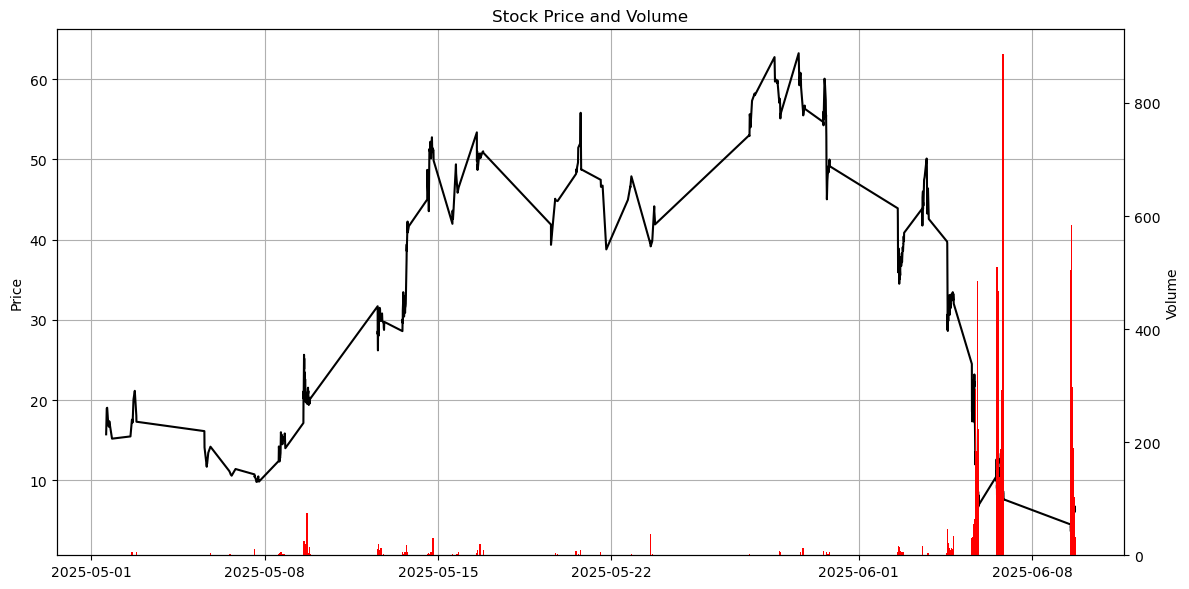

,Open,High,Low,Close,Volume
Date,,,,,
2025-05-01 14:17:00,15.74,15.74,15.74,15.74,1.0
2025-05-01 14:52:00,19.00,19.00,19.00,19.00,1.0
2025-05-01 15:17:00,19.05,19.05,19.05,19.05,1.0
2025-05-01 16:23:00,16.85,16.85,16.85,16.85,1.0
2025-05-01 16:59:00,16.68,16.68,16.68,16.68,1.0
2025-05-01 17:21:00,17.37,17.37,17.37,17.37,1.0
2025-05-01 19:59:00,15.20,15.20,15.20,15.20,1.0
2025-05-02 13:51:00,15.48,15.48,15.48,15.48,1.0
2025-05-02 15:16:00,17.55,17.55,17.55,17.55,5.0


In [213]:

import pandas as pd
import matplotlib.pyplot as plt



import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot closing price
ax1.plot(data.index, data['Close'], color='black', label='Close Price')
ax1.set_ylabel('Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title('Stock Price and Volume')
ax1.grid(True)

# Create a secondary y-axis for volume
ax2 = ax1.twinx()
ax2.bar(data.index, data['Volume'], color='red', alpha=1, label='Volume', width =0.05)
ax2.set_ylabel('Volume', color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()
plt.show()

data.head(10)

/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_19203/114285320.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.resample('1min').ffill())


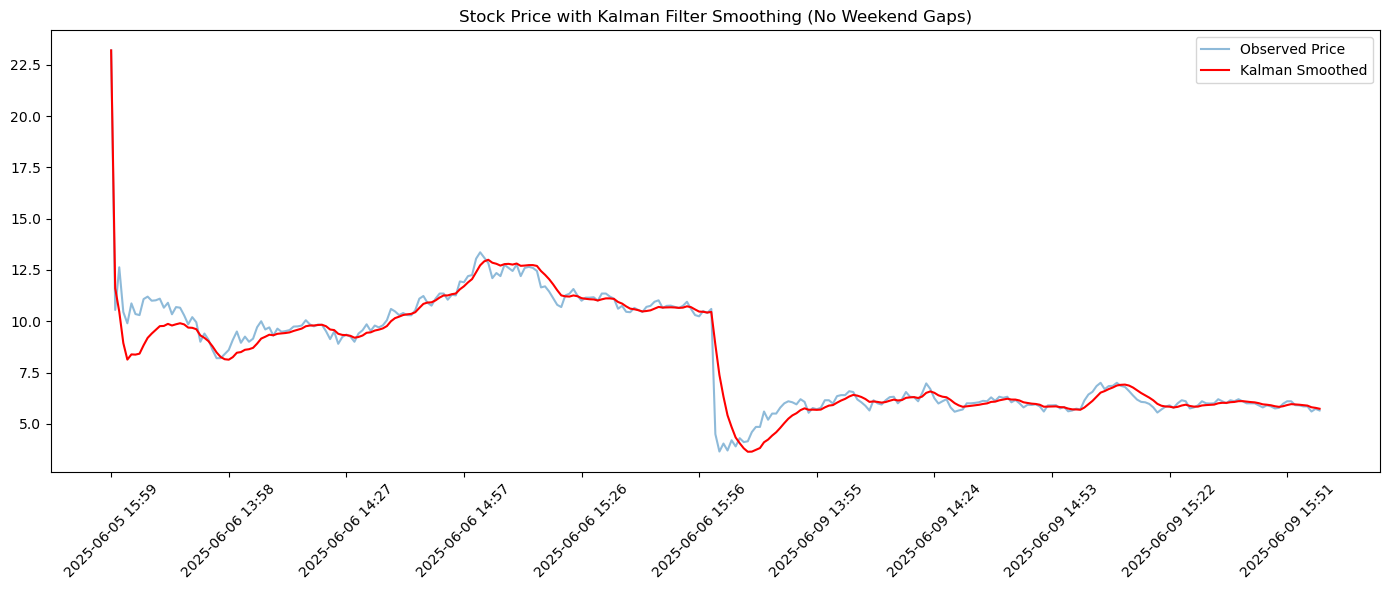

,Open,High,Low,Close,Volume,date,Kalman
Date,,,,,,,
2025-06-09 15:50:00,5.90,6.00,5.87,5.98,40.0,2025-06-09,5.857915
2025-06-09 15:51:00,5.95,6.10,5.95,6.10,31.0,2025-06-09,5.914516
2025-06-09 15:52:00,6.16,6.20,6.10,6.10,189.0,2025-06-09,5.959695
2025-06-09 15:53:00,6.05,6.05,5.91,5.91,51.0,2025-06-09,5.945322
2025-06-09 15:54:00,5.96,5.96,5.90,5.90,12.0,2025-06-09,5.931430
2025-06-09 15:55:00,5.83,5.85,5.83,5.85,12.0,2025-06-09,5.907378
2025-06-09 15:56:00,6.00,6.00,5.85,5.85,15.0,2025-06-09,5.888592
2025-06-09 15:57:00,5.80,5.80,5.57,5.60,94.0,2025-06-09,5.807874
2025-06-09 15:58:00,5.58,5.73,5.58,5.73,24.0,2025-06-09,5.778938


In [ ]:
#KALMAN FILTER
#Timeframe 
days = 4



# Remove weekends (Saturday=5, Sunday=6)
import pandas as pd

# Remove weekends and keep only regular trading hours
datafix = data[data.index.weekday < 5]
datafix = datafix[(datafix.index.hour < 16) & (datafix.index.hour > 9)]

# Filter for only the last 7 days in the data
last_date = datafix.index.max()
one_week_ago = last_date - pd.Timedelta(days=days)
datafix = datafix[datafix.index >= one_week_ago]


# Assume your DataFrame is called 'datafix' and has a DatetimeIndex

# Create a 'date' column for grouping
datafix = datafix.copy()
datafix['date'] = datafix.index.date

# Group by date and resample within each day to 1-minute frequency, forward-filling missing times
datafix_filled = (
    datafix
    .groupby('date')
    .apply(lambda x: x.resample('1min').ffill())
    .reset_index(level=0, drop=True)
)

# Drop the 'date' column if you don't need it
datafix_filled = datafix_filled.drop(columns='date')

##Kalman filter Price 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

# Assume 'data' is your DataFrame with a 'Close' column and datetime index

# Initialize Kalman Filter for 1D price series
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([datafix['Close'].iloc[0], 0.])      # initial state (price, velocity)
kf.F = np.array([[1., .1], [0., 1.]])            # state transition matrix
kf.H = np.array([[1., 0.]])                      # measurement function
kf.P *= 1000.                                    # covariance matrix
kf.R = 1.                                        # measurement noise
kf.Q = np.eye(2)*0.05                              # process noise

filtered_state_means = []
for price in datafix['Close']:
    kf.predict()
    kf.update(price)
    filtered_state_means.append(kf.x[0])

datafix['Kalman'] = filtered_state_means

# Plotting
plt.figure(figsize=(14,6))
plt.plot(datafix.reset_index().index, datafix['Close'], label='Observed Price', alpha=0.5)
plt.plot(datafix.reset_index().index, datafix['Kalman'], label='Kalman Smoothed', color='red')
plt.title('Stock Price with Kalman Filter Smoothing (No Weekend Gaps)')
plt.xticks(
    ticks=range(0, len(datafix), max(1, len(datafix)//10)), 
    labels=datafix.index[::max(1, len(datafix)//10)].strftime('%Y-%m-%d %H:%M'),
    rotation=45
)
plt.legend()
plt.tight_layout()
plt.show()






datafix.tail(10)


In [228]:
##KALMAN FILTER ROC
datafix["Kalman_Roc"] = datafix['Kalman'].pct_change().dropna() * 100  # Convert to percentage change
datafix.tail(10)

,Open,High,Low,Close,Volume,date,Kalman,Kalman_Roc
Date,,,,,,,,
2025-06-09 15:50:00,5.90,6.00,5.87,5.98,40.0,2025-06-09,5.857915,0.525121
2025-06-09 15:51:00,5.95,6.10,5.95,6.10,31.0,2025-06-09,5.914516,0.966239
2025-06-09 15:52:00,6.16,6.20,6.10,6.10,189.0,2025-06-09,5.959695,0.763853
2025-06-09 15:53:00,6.05,6.05,5.91,5.91,51.0,2025-06-09,5.945322,-0.241162
2025-06-09 15:54:00,5.96,5.96,5.90,5.90,12.0,2025-06-09,5.931430,-0.233673
2025-06-09 15:55:00,5.83,5.85,5.83,5.85,12.0,2025-06-09,5.907378,-0.405488
2025-06-09 15:56:00,6.00,6.00,5.85,5.85,15.0,2025-06-09,5.888592,-0.318012
2025-06-09 15:57:00,5.80,5.80,5.57,5.60,94.0,2025-06-09,5.807874,-1.370752
2025-06-09 15:58:00,5.58,5.73,5.58,5.73,24.0,2025-06-09,5.778938,-0.498228


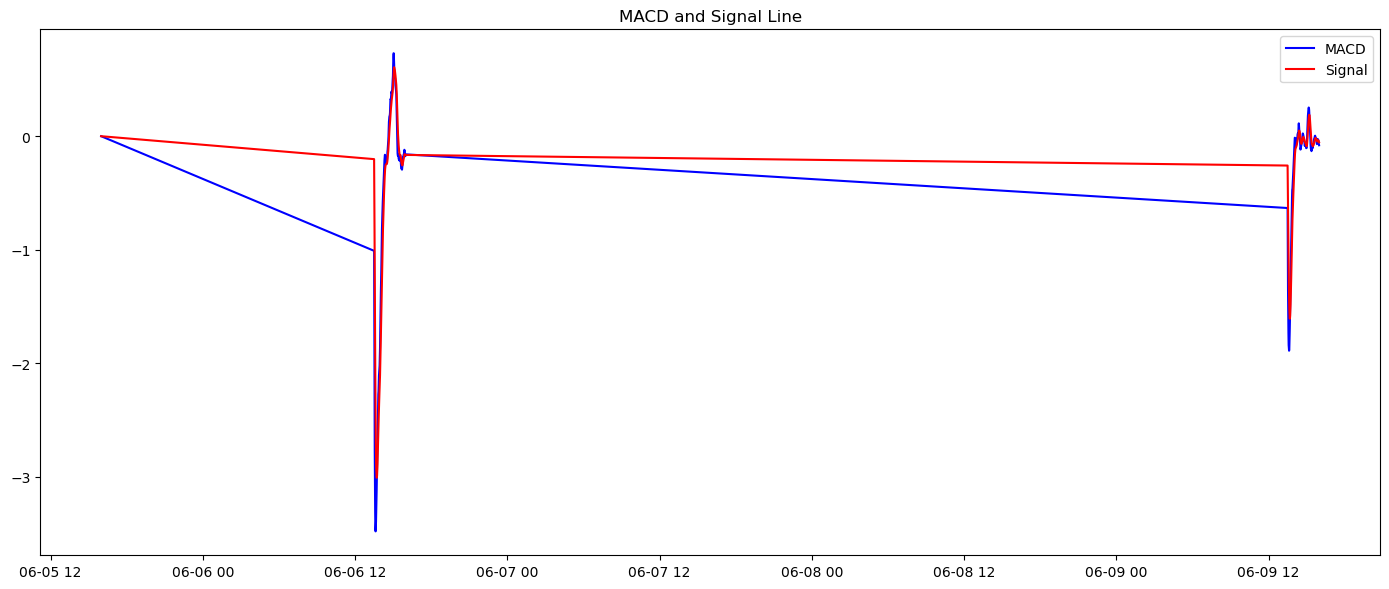

In [233]:
#MACD
# Calculate MACD and Signal Line
def calculate_macd(df, close_col='Close', fast=12, slow=26, signal=9):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df['MACD'] = macd
    df['Signal'] = signal_line
    df['MACD_Hist'] = macd_hist
    return df

macdata = calculate_macd(datafix, close_col='Close', fast=12, slow=26, signal=9)

# Plotting MACD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Split MACD histogram into positive and negative for color distinction
macd_hist = macdata['MACD_Hist']
pos_hist = macd_hist.copy()
neg_hist = macd_hist.copy()
pos_hist[pos_hist < 0] = 0
neg_hist[neg_hist > 0] = 0

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(macdata.index, macdata['MACD'], label='MACD', color='blue')
plt.plot(macdata.index, macdata['Signal'], label='Signal', color='red')
plt.title('MACD and Signal Line')
plt.legend()
plt.tight_layout()
plt.show()


